Notebook file demonstrating how to extract camera parameters in the scene and how these camera parameters relate to the given views.

In [ ]:
import os
import numpy as np
import quaternion

import matplotlib.pyplot as plt
%matplotlib inline

import habitat

import torch.nn.functional as F
import torch
from torchvision.transforms import ToTensor

os.chdir('./..')

In [2]:
# Set up the environment for testing
config = habitat.get_config(config_paths="./configs/tasks/pointnav_rgbd.yaml")

# Can also do directly in the config file
config.defrost()
config.SIMULATOR.DEPTH_SENSOR.NORMALIZE_DEPTH = False
config.freeze()

# Intrinsic parameters, assuming width matches height. Requires a simple refactor otherwise
W = config.SIMULATOR.DEPTH_SENSOR.WIDTH
H = config.SIMULATOR.DEPTH_SENSOR.HEIGHT

assert(W == H)
hfov = float(config.SIMULATOR.DEPTH_SENSOR.HFOV) * np.pi / 180.


env = habitat.Env(config=config)


obs = env.reset()
initial_state = env._sim.get_agent_state(0)
init_translation = initial_state.position
init_rotation = initial_state.rotation

2019-06-09 19:32:54,146 initializing sim Sim-v0
I0609 19:32:54.151781 55568 simulator.py:78] Loaded navmesh data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh
2019-06-09 19:32:55,566 initializing task Nav-v0


In [3]:
# Randomly permute the rotation

def uniform_quat(original_angle):
    original_euler = quaternion.as_euler_angles(original_angle)
    euler_angles = np.array([(np.random.rand() - 0.5) * np.pi / 9. + original_euler[0],
                             (np.random.rand() - 0.5) * np.pi / 9. + original_euler[1],
                             (np.random.rand() - 0.5) * np.pi / 9. + original_euler[2]])
    quaternions = quaternion.from_euler_angles(euler_angles)
    
    
    return quaternions

In [4]:
# Generate two random, overlapping views

depths = []
rgbs = []
cameras = []


for i in range(0, 2):
    rotation = uniform_quat(init_rotation)
    translation = init_translation + np.random.rand(3,) * 0.5 - 0.25
    
    obs = env._sim.get_observations_at(position=translation, rotation=rotation, keep_agent_at_new_pose=True)
    depths += [obs["depth"][...,0]]
    rgbs += [obs["rgb"]]
    
    cameras += [env._sim.get_agent_state()]

env.close()

In [5]:
# Intrinsic parameters, K

K = np.array([
    [1 / np.tan(hfov / 2.), 0., 0., 0.],
    [0., 1 / np.tan(hfov / 2.), 0., 0.],
    [0., 0.,  1, 0],
    [0., 0., 0, 1]])

# Now get an approximation for the true world coordinates -- see if they make sense
# [-1, 1] for x and [1, -1] for y as array indexing is y-down while world is y-up
xs, ys = np.meshgrid(np.linspace(-1,1,W), np.linspace(1,-1,W)) 
depth = depths[0].reshape(1,W,W) 
xs = xs.reshape(1,W,W)
ys = ys.reshape(1,W,W)

# Unproject
# negate depth as the camera looks along -Z
xys = np.vstack((xs * depth , ys * depth, -depth, np.ones(depth.shape)))
xys = xys.reshape(4, -1)
xy_c0 = np.matmul(np.linalg.inv(K), xys)

# Now load in the cameras, are in the format camera --> world
# Camera 1:
quaternion_0 = cameras[0].sensor_states['depth'].rotation
translation_0 = cameras[0].sensor_states['depth'].position
rotation_0 = quaternion.as_rotation_matrix(quaternion_0)
T_world_camera0 = np.eye(4)
T_world_camera0[0:3,0:3] = rotation_0
T_world_camera0[0:3,3] = translation_0

# Camera 2:
translation_1 = cameras[1].sensor_states['depth'].position
quaternion_1 = cameras[1].sensor_states['depth'].rotation
rotation_1 = quaternion.as_rotation_matrix(quaternion_1)
T_world_camera1 = np.eye(4)
T_world_camera1[0:3,0:3] =  rotation_1
T_world_camera1[0:3,3] = translation_1

# Invert to get world --> camera
T_camera1_world = np.linalg.inv(T_world_camera1)

# Transformation matrix between views
# Aka the position of camera0 in camera1's coordinate frame
T_camera1_camera0 = np.matmul(T_camera1_world, T_world_camera0)

# Finally transform actual points
xy_c1 = np.matmul(T_camera1_camera0, xy_c0)
xy_newimg = np.matmul(K, xy_c1)

# Normalize by negative depth
xys_newimg = xy_newimg[0:2,:] / -xy_newimg[2:3,:]
# Flip back to y-down to match array indexing
xys_newimg[1] *= -1
print('Transformed points')

Transformed points


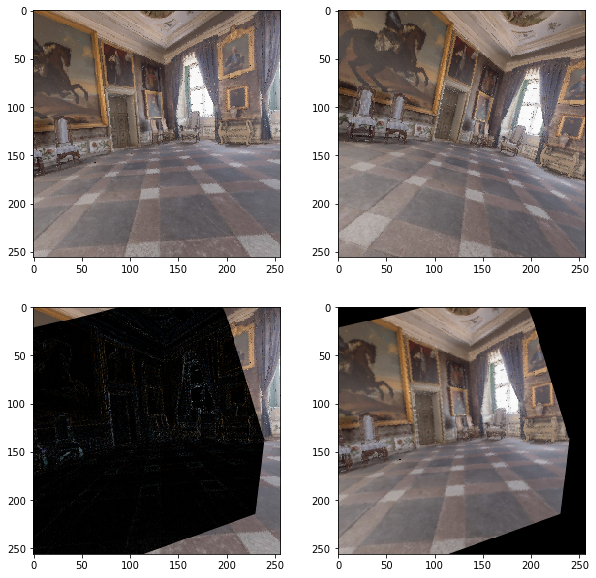

In [6]:
# And visualise this new transformation

# Create sampler
sampler = torch.Tensor(xys_newimg).view(2, W, W).permute(1,2,0).unsqueeze(0)

# Create generated image
img1_tensor = ToTensor()(rgbs[0]).unsqueeze(0)
img2_tensor = ToTensor()(rgbs[1]).unsqueeze(0)
img2_warped = F.grid_sample(img2_tensor, sampler)

# Visualise
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.imshow(img1_tensor.squeeze().permute(1,2,0))
ax1 = plt.subplot(222)
ax1.imshow(img2_tensor.squeeze().permute(1,2,0))
ax1 = plt.subplot(223)
ax1.imshow(np.abs(img2_warped.squeeze().permute(1,2,0) - img1_tensor.squeeze().permute(1,2,0)))

ax1 = plt.subplot(224)
plt.imshow(img2_warped.squeeze().permute(1,2,0))